# Visualization

/data/lige/miniconda3/envs/HKNet/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


找到 514 个匹配样本
缺失 1 个样本的 clade 信息，例如：['NC063383']
清洗后数据集包含 514 个样本


/data/lige/miniconda3/envs/HKNet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


t-SNE 降维后 shape: (514, 2)


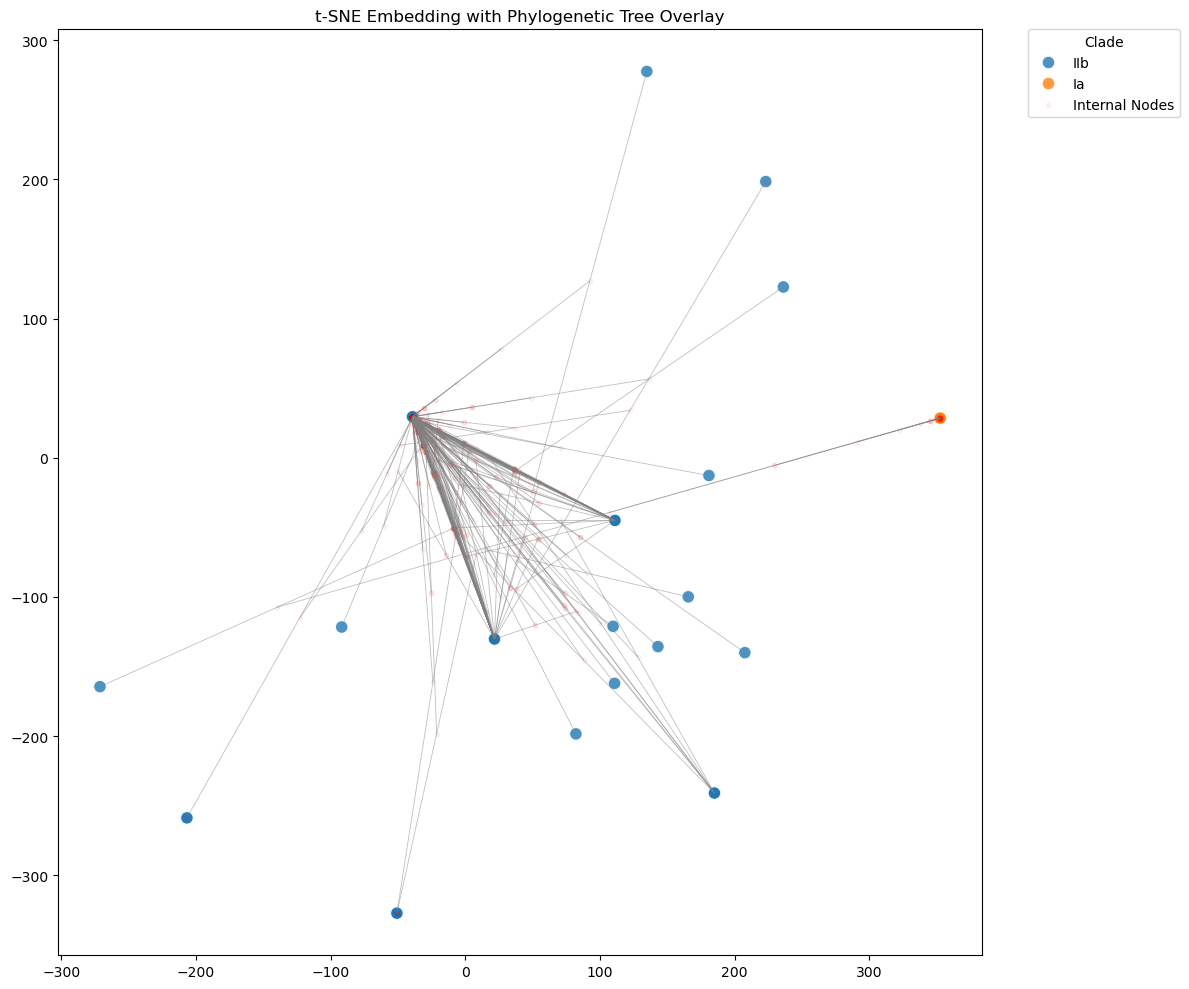

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from Bio import Phylo
import networkx as nx
import uuid
from matplotlib.collections import LineCollection

### === 1. 加载嵌入数据 & metadata === ###
train_data = torch.load("./MPXV/OPG021/train.pt")
X = train_data['vector'].numpy()  # (n_samples, seq_length)
accessions = train_data['accession']

# 加载 metadata
meta = pd.read_csv("./data/metadata.tsv", sep="\t")
meta = meta[['accession', 'region', 'country', 'date', 'clade']]

# 创建 accession -> clade 的映射字典
acc2clade = pd.Series(meta.clade.values, index=meta.accession).to_dict()

# 匹配 clade 信息
matched_clades = []
missing_acc = []

for acc in accessions:
    if acc in acc2clade:
        matched_clades.append(acc2clade[acc])
    else:
        matched_clades.append(np.nan)
        missing_acc.append(acc)

# 输出匹配情况
print(f"找到 {len(matched_clades) - len(missing_acc)} 个匹配样本")
print(f"缺失 {len(missing_acc)} 个样本的 clade 信息，例如：{missing_acc[:5]}")

# 创建最终数据集
dataset = pd.DataFrame({
    'accession': accessions,
    'embedding': list(X),
    'clade': matched_clades
})

# 只保留有 clade 的样本
clean_dataset = dataset.dropna(subset=['clade']).reset_index(drop=True)
print(f"清洗后数据集包含 {len(clean_dataset)} 个样本")

# === 2. 执行 t-SNE 降维 === #
X = np.stack(clean_dataset['embedding'])  # shape (N, D)
clade_labels = clean_dataset['clade'].values

# 数值编码 Clade
le = LabelEncoder()
clade_encoded = le.fit_transform(clade_labels)

# t-SNE 降到 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X)
print(f"t-SNE 降维后 shape: {X_tsne.shape}")

# 生成 accession -> 2D 坐标映射 (仅叶节点)
accessions = clean_dataset['accession'].values
acc_to_coord = {acc: (x, y) for acc, (x, y) in zip(accessions, X_tsne)}

### === 3. 解析系统发育树并构建邻接表 === ###
tree_path = "./data/selected_alignments_with_trees/RAxML_bestTree.Coronaviridae_OPG021_mafft_nobl.tree"
tree = Phylo.read(tree_path, "newick")

adj_list = {}
internal_counter = 0

def build_adj_list(clade):
    """递归构建树的邻接表"""
    global internal_counter
    # 叶节点用 accession ID, 内部节点用 internal_X
    if clade.name:
        current_id = clade.name
    else:
        current_id = f"internal_{internal_counter}"
        internal_counter += 1

    # 获取所有子节点的 ID
    children_ids = []
    for child_clade in clade.clades:
        child_id = build_adj_list(child_clade)
        children_ids.append(child_id)

    # 记录当前节点的子节点
    adj_list[current_id] = children_ids
    return current_id

# 构建拓扑关系
root_id = build_adj_list(tree.root)

# === 4. 计算内部节点的 2D 坐标 (均值插值) ===
node_coords = acc_to_coord.copy()
for node in adj_list.keys():
    if node not in node_coords:  # 仅对内部节点处理
        children = adj_list[node]
        valid_children = [node_coords[child] for child in children if child in node_coords]

        if valid_children:  # 确保有可用的子节点
            node_coords[node] = np.mean(valid_children, axis=0)

### === 5. 绘图 (scatter plot + tree topology) === ###
plt.figure(figsize=(12, 10))

# 画叶节点 (带颜色)
leaf_x, leaf_y = zip(*[node_coords[acc] for acc in accessions])
sns.scatterplot(x=leaf_x, y=leaf_y, hue=clean_dataset['clade'], palette="tab10", s=80, alpha=0.8, edgecolor='w')

# 画内部节点 (透明度 0.2)
internal_x, internal_y = zip(*[node_coords[node] for node in node_coords if node.startswith("internal")])
plt.scatter(internal_x, internal_y, s=10, c='red', alpha=0.05, label="Internal Nodes")

# 画系统发育树的拓扑连线
segments = []
for parent, children in adj_list.items():
    for child in children:
        if parent in node_coords and child in node_coords:
            segments.append([node_coords[parent], node_coords[child]])

lc = LineCollection(segments, colors='gray', linewidths=0.6, alpha=0.5)
plt.gca().add_collection(lc)

### === 6. 调整可视化 === ###
plt.legend(title="Clade", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("t-SNE Embedding with Phylogenetic Tree Overlay")
plt.tight_layout()
plt.show()


找到 514 个匹配样本
缺失 1 个样本的 clade 信息，例如：['NC063383']
清洗后数据集包含 514 个样本


/data/lige/miniconda3/envs/HKNet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


t-SNE 降维后 shape: (514, 2)


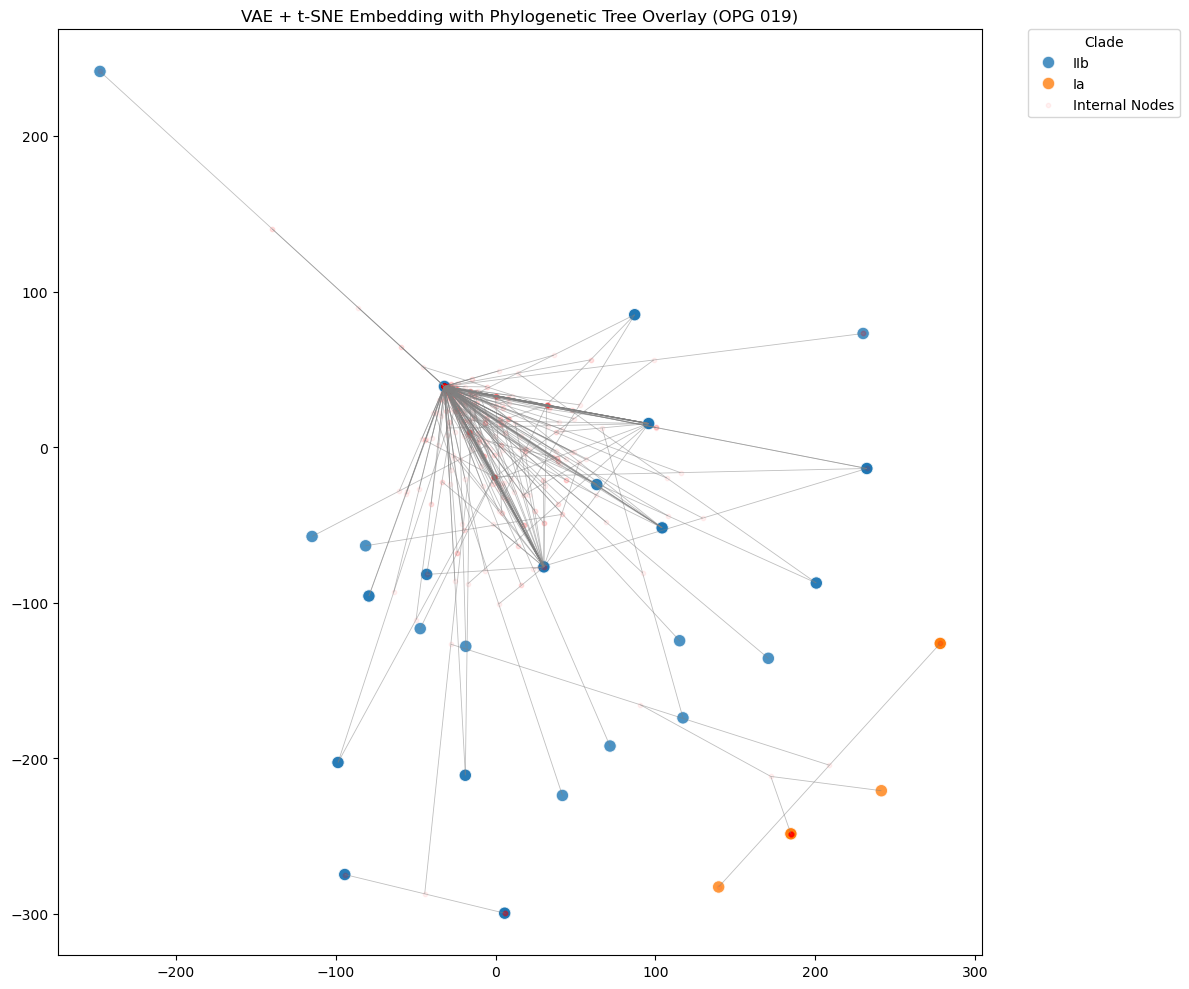

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from Bio import Phylo
import networkx as nx
import uuid
from matplotlib.collections import LineCollection

### === 1. 加载嵌入数据 & metadata === ###
train_data = torch.load("./MPXV/OPG019/train.pt")
X = train_data['vector'].numpy()  # (n_samples, seq_length)
accessions = train_data['accession']

# 加载 metadata
meta = pd.read_csv("./data/metadata.tsv", sep="\t")
meta = meta[['accession', 'region', 'country', 'date', 'clade']]

# 创建 accession -> clade 的映射字典
acc2clade = pd.Series(meta.clade.values, index=meta.accession).to_dict()

# 匹配 clade 信息
matched_clades = []
missing_acc = []

for acc in accessions:
    if acc in acc2clade:
        matched_clades.append(acc2clade[acc])
    else:
        matched_clades.append(np.nan)
        missing_acc.append(acc)

# 输出匹配情况
print(f"找到 {len(matched_clades) - len(missing_acc)} 个匹配样本")
print(f"缺失 {len(missing_acc)} 个样本的 clade 信息，例如：{missing_acc[:5]}")

# 创建最终数据集
dataset = pd.DataFrame({
    'accession': accessions,
    'embedding': list(X),
    'clade': matched_clades
})

# 只保留有 clade 的样本
clean_dataset = dataset.dropna(subset=['clade']).reset_index(drop=True)
print(f"清洗后数据集包含 {len(clean_dataset)} 个样本")

# === 2. 执行 t-SNE 降维 === #
X = np.stack(clean_dataset['embedding'])  # shape (N, D)
clade_labels = clean_dataset['clade'].values

# 数值编码 Clade
le = LabelEncoder()
clade_encoded = le.fit_transform(clade_labels)

# t-SNE 降到 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X)
print(f"t-SNE 降维后 shape: {X_tsne.shape}")

# 生成 accession -> 2D 坐标映射 (仅叶节点)
accessions = clean_dataset['accession'].values
acc_to_coord = {acc: (x, y) for acc, (x, y) in zip(accessions, X_tsne)}

### === 3. 解析系统发育树并构建邻接表 === ###
tree_path = "./data/selected_alignments_with_trees/RAxML_bestTree.Coronaviridae_OPG019_mafft_nobl.tree"
tree = Phylo.read(tree_path, "newick")

adj_list = {}
internal_counter = 0

def build_adj_list(clade):
    """递归构建树的邻接表"""
    global internal_counter
    # 叶节点用 accession ID, 内部节点用 internal_X
    if clade.name:
        current_id = clade.name
    else:
        current_id = f"internal_{internal_counter}"
        internal_counter += 1

    # 获取所有子节点的 ID
    children_ids = []
    for child_clade in clade.clades:
        child_id = build_adj_list(child_clade)
        children_ids.append(child_id)

    # 记录当前节点的子节点
    adj_list[current_id] = children_ids
    return current_id

# 构建拓扑关系
root_id = build_adj_list(tree.root)

# === 4. 计算内部节点的 2D 坐标 (均值插值) ===
node_coords = acc_to_coord.copy()
for node in adj_list.keys():
    if node not in node_coords:  # 仅对内部节点处理
        children = adj_list[node]
        valid_children = [node_coords[child] for child in children if child in node_coords]

        if valid_children:  # 确保有可用的子节点
            node_coords[node] = np.mean(valid_children, axis=0)

### === 5. 绘图 (scatter plot + tree topology) === ###
plt.figure(figsize=(12, 10))

# 画叶节点 (带颜色)
leaf_x, leaf_y = zip(*[node_coords[acc] for acc in accessions])
sns.scatterplot(x=leaf_x, y=leaf_y, hue=clean_dataset['clade'], palette="tab10", s=80, alpha=0.8, edgecolor='w')

# 画内部节点 (透明度 0.2)
internal_x, internal_y = zip(*[node_coords[node] for node in node_coords if node.startswith("internal")])
plt.scatter(internal_x, internal_y, s=10, c='red', alpha=0.05, label="Internal Nodes")

# 画系统发育树的拓扑连线
segments = []
for parent, children in adj_list.items():
    for child in children:
        if parent in node_coords and child in node_coords:
            segments.append([node_coords[parent], node_coords[child]])

lc = LineCollection(segments, colors='gray', linewidths=0.6, alpha=0.5)
plt.gca().add_collection(lc)

### === 6. 调整可视化 === ###
plt.legend(title="Clade", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("VAE + t-SNE Embedding with Phylogenetic Tree Overlay (OPG 019)")
plt.tight_layout()
plt.show()


找到 514 个匹配样本
缺失 1 个样本的 clade 信息，例如：['NC063383']
清洗后数据集包含 514 个样本


/data/lige/miniconda3/envs/HKNet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


t-SNE 降维后 shape: (514, 2)


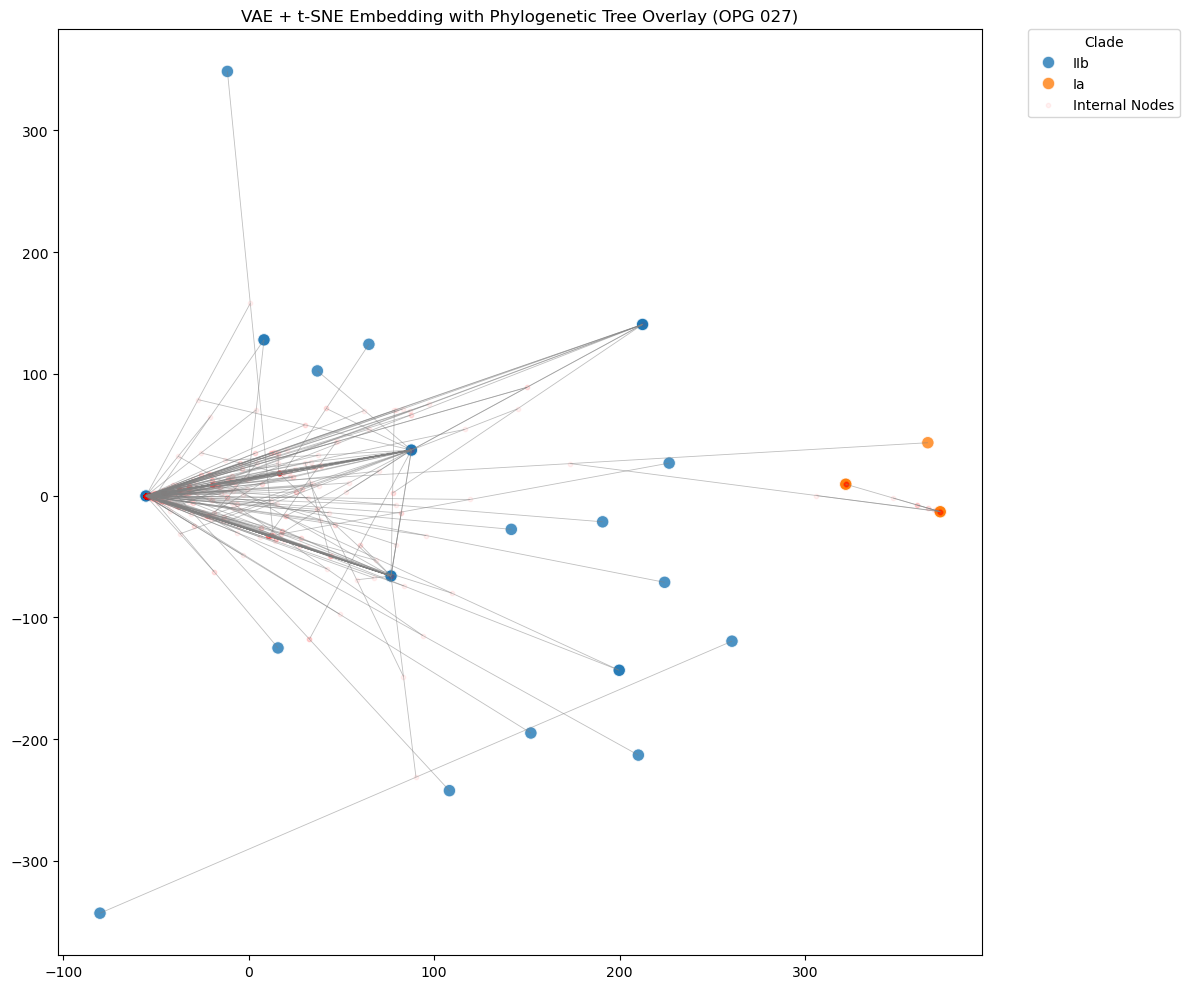

In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from Bio import Phylo
import networkx as nx
import uuid
from matplotlib.collections import LineCollection

### === 1. 加载嵌入数据 & metadata === ###
train_data = torch.load("./MPXV/OPG027/train.pt")
X = train_data['vector'].numpy()  # (n_samples, seq_length)
accessions = train_data['accession']

# 加载 metadata
meta = pd.read_csv("./data/metadata.tsv", sep="\t")
meta = meta[['accession', 'region', 'country', 'date', 'clade']]

# 创建 accession -> clade 的映射字典
acc2clade = pd.Series(meta.clade.values, index=meta.accession).to_dict()

# 匹配 clade 信息
matched_clades = []
missing_acc = []

for acc in accessions:
    if acc in acc2clade:
        matched_clades.append(acc2clade[acc])
    else:
        matched_clades.append(np.nan)
        missing_acc.append(acc)

# 输出匹配情况
print(f"找到 {len(matched_clades) - len(missing_acc)} 个匹配样本")
print(f"缺失 {len(missing_acc)} 个样本的 clade 信息，例如：{missing_acc[:5]}")

# 创建最终数据集
dataset = pd.DataFrame({
    'accession': accessions,
    'embedding': list(X),
    'clade': matched_clades
})

# 只保留有 clade 的样本
clean_dataset = dataset.dropna(subset=['clade']).reset_index(drop=True)
print(f"清洗后数据集包含 {len(clean_dataset)} 个样本")

# === 2. 执行 t-SNE 降维 === #
X = np.stack(clean_dataset['embedding'])  # shape (N, D)
clade_labels = clean_dataset['clade'].values

# 数值编码 Clade
le = LabelEncoder()
clade_encoded = le.fit_transform(clade_labels)

# t-SNE 降到 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X)
print(f"t-SNE 降维后 shape: {X_tsne.shape}")

# 生成 accession -> 2D 坐标映射 (仅叶节点)
accessions = clean_dataset['accession'].values
acc_to_coord = {acc: (x, y) for acc, (x, y) in zip(accessions, X_tsne)}

### === 3. 解析系统发育树并构建邻接表 === ###
tree_path = "./data/selected_alignments_with_trees/RAxML_bestTree.Coronaviridae_OPG027_mafft_nobl.tree"
tree = Phylo.read(tree_path, "newick")

adj_list = {}
internal_counter = 0

def build_adj_list(clade):
    """递归构建树的邻接表"""
    global internal_counter
    # 叶节点用 accession ID, 内部节点用 internal_X
    if clade.name:
        current_id = clade.name
    else:
        current_id = f"internal_{internal_counter}"
        internal_counter += 1

    # 获取所有子节点的 ID
    children_ids = []
    for child_clade in clade.clades:
        child_id = build_adj_list(child_clade)
        children_ids.append(child_id)

    # 记录当前节点的子节点
    adj_list[current_id] = children_ids
    return current_id

# 构建拓扑关系
root_id = build_adj_list(tree.root)

# === 4. 计算内部节点的 2D 坐标 (均值插值) ===
node_coords = acc_to_coord.copy()
for node in adj_list.keys():
    if node not in node_coords:  # 仅对内部节点处理
        children = adj_list[node]
        valid_children = [node_coords[child] for child in children if child in node_coords]

        if valid_children:  # 确保有可用的子节点
            node_coords[node] = np.mean(valid_children, axis=0)

### === 5. 绘图 (scatter plot + tree topology) === ###
plt.figure(figsize=(12, 10))

# 画叶节点 (带颜色)
leaf_x, leaf_y = zip(*[node_coords[acc] for acc in accessions])
sns.scatterplot(x=leaf_x, y=leaf_y, hue=clean_dataset['clade'], palette="tab10", s=80, alpha=0.8, edgecolor='w')

# 画内部节点 (透明度 0.2)
internal_x, internal_y = zip(*[node_coords[node] for node in node_coords if node.startswith("internal")])
plt.scatter(internal_x, internal_y, s=10, c='red', alpha=0.05, label="Internal Nodes")

# 画系统发育树的拓扑连线
segments = []
for parent, children in adj_list.items():
    for child in children:
        if parent in node_coords and child in node_coords:
            segments.append([node_coords[parent], node_coords[child]])

lc = LineCollection(segments, colors='gray', linewidths=0.6, alpha=0.5)
plt.gca().add_collection(lc)

### === 6. 调整可视化 === ###
plt.legend(title="Clade", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("VAE + t-SNE Embedding with Phylogenetic Tree Overlay (OPG 027)")
plt.tight_layout()
plt.show()
